# Fake Instagram account detector

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,accuracy_score,roc_curve,confusion_matrix

In [7]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 

In [9]:
# Load the training dataset
instagram_df_train = pd.read_csv('insta_train.csv')
instagram_df_train

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.00,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.00,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.00,0,0,0,1,13,159,98,0
3,1,0.00,1,0.00,0,82,0,0,679,414,651,0
4,1,0.00,2,0.00,0,0,0,1,6,151,126,0
...,...,...,...,...,...,...,...,...,...,...,...,...
571,1,0.55,1,0.44,0,0,0,0,33,166,596,1
572,1,0.38,1,0.33,0,21,0,0,44,66,75,1
573,1,0.57,2,0.00,0,0,0,0,4,96,339,1
574,1,0.57,1,0.00,0,11,0,0,0,57,73,1


In [10]:
# Load the testing data
instagram_df_test = pd.read_csv('insta_test.csv')
instagram_df_test 

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0
...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,0.29,1,0.00,0,0,0,0,13,114,811,1
116,1,0.40,1,0.00,0,0,0,0,4,150,164,1
117,1,0.00,2,0.00,0,0,0,0,3,833,3572,1
118,0,0.17,1,0.00,0,0,0,0,1,219,1695,1


In [11]:
# Getting dataframe info
instagram_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           576 non-null    int64  
 1   nums/length username  576 non-null    float64
 2   fullname words        576 non-null    int64  
 3   nums/length fullname  576 non-null    float64
 4   name==username        576 non-null    int64  
 5   description length    576 non-null    int64  
 6   external URL          576 non-null    int64  
 7   private               576 non-null    int64  
 8   #posts                576 non-null    int64  
 9   #followers            576 non-null    int64  
 10  #follows              576 non-null    int64  
 11  fake                  576 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 54.1 KB


In [12]:
# Get the statistical summary of the dataframe
instagram_df_train.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,5.760000e+02,576.000000,576.000000
mean,0.701389,0.163837,1.460069,0.036094,0.034722,22.623264,0.116319,0.381944,107.489583,8.530724e+04,508.381944,0.500000
std,0.458047,0.214096,1.052601,0.125121,0.183234,37.702987,0.320886,0.486285,402.034431,9.101485e+05,917.981239,0.500435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.900000e+01,57.500000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.505000e+02,229.500000,0.500000
75%,1.000000,0.310000,2.000000,0.000000,0.000000,34.000000,0.000000,1.000000,81.500000,7.160000e+02,589.500000,1.000000
max,1.000000,0.920000,12.000000,1.000000,1.000000,150.000000,1.000000,1.000000,7389.000000,1.533854e+07,7500.000000,1.000000


In [13]:
# Checking if null values exist
instagram_df_train.isnull().sum()

profile pic             0
nums/length username    0
fullname words          0
nums/length fullname    0
name==username          0
description length      0
external URL            0
private                 0
#posts                  0
#followers              0
#follows                0
fake                    0
dtype: int64

In [14]:
# Get the number of unique values in the "profile pic" feature
instagram_df_train['profile pic'].value_counts()

1    404
0    172
Name: profile pic, dtype: int64

In [15]:
# Get the number of unique values in "fake" (Target column)
instagram_df_train['fake'].value_counts()

1    288
0    288
Name: fake, dtype: int64

In [52]:
# Getting dataframe info
instagram_df_test.info()
# Get the statistical summary of the dataframe
instagram_df_test.describe()
# Checking null values
instagram_df_test.isnull().sum()
# Get the number of unique values in the profile pic
instagram_df_test['profile pic'].value_counts()
# Get the number of unique values
instagram_df_test['fake'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           120 non-null    int64  
 1   nums/length username  120 non-null    float64
 2   fullname words        120 non-null    int64  
 3   nums/length fullname  120 non-null    float64
 4   name==username        120 non-null    int64  
 5   description length    120 non-null    int64  
 6   external URL          120 non-null    int64  
 7   private               120 non-null    int64  
 8   #posts                120 non-null    int64  
 9   #followers            120 non-null    int64  
 10  #follows              120 non-null    int64  
 11  fake                  120 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 11.4 KB


1    60
0    60
Name: fake, dtype: int64

<AxesSubplot:xlabel='fake', ylabel='count'>

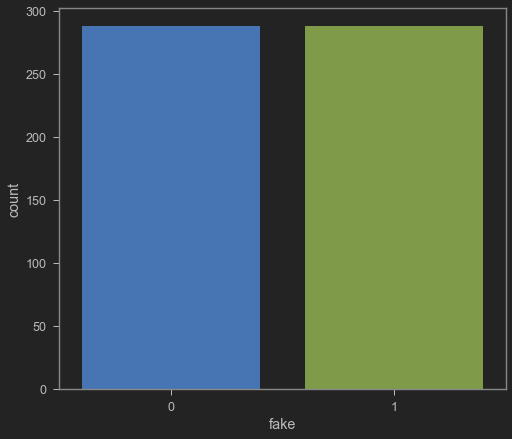

In [27]:
# Visualize the data
sns.countplot(x=instagram_df_train['fake'])

<AxesSubplot:xlabel='private', ylabel='count'>

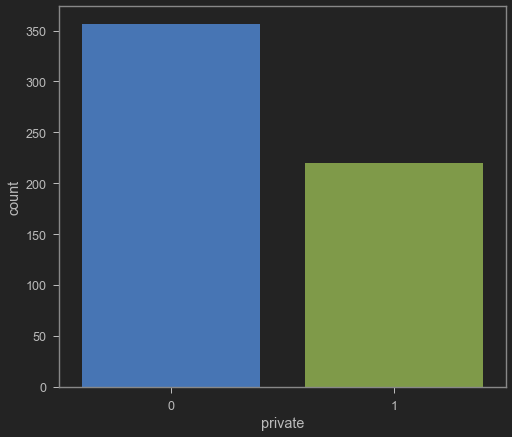

In [28]:
# Visualize the private column data
sns.countplot(x=instagram_df_train['private'])

<AxesSubplot:xlabel='profile pic', ylabel='count'>

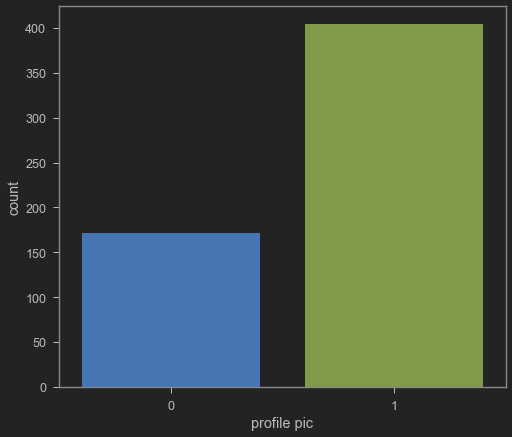

In [29]:
# Visualize the "profile pic" column data
sns.countplot(x=instagram_df_train['profile pic'])

<Figure size 1440x720 with 0 Axes>

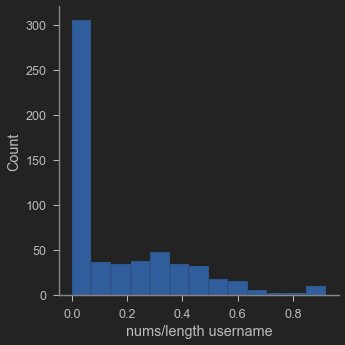

In [31]:
# Visualize the data
plt.figure(figsize = (20, 10))
sns.displot(instagram_df_train['nums/length username'])

<Figure size 1440x1440 with 0 Axes>

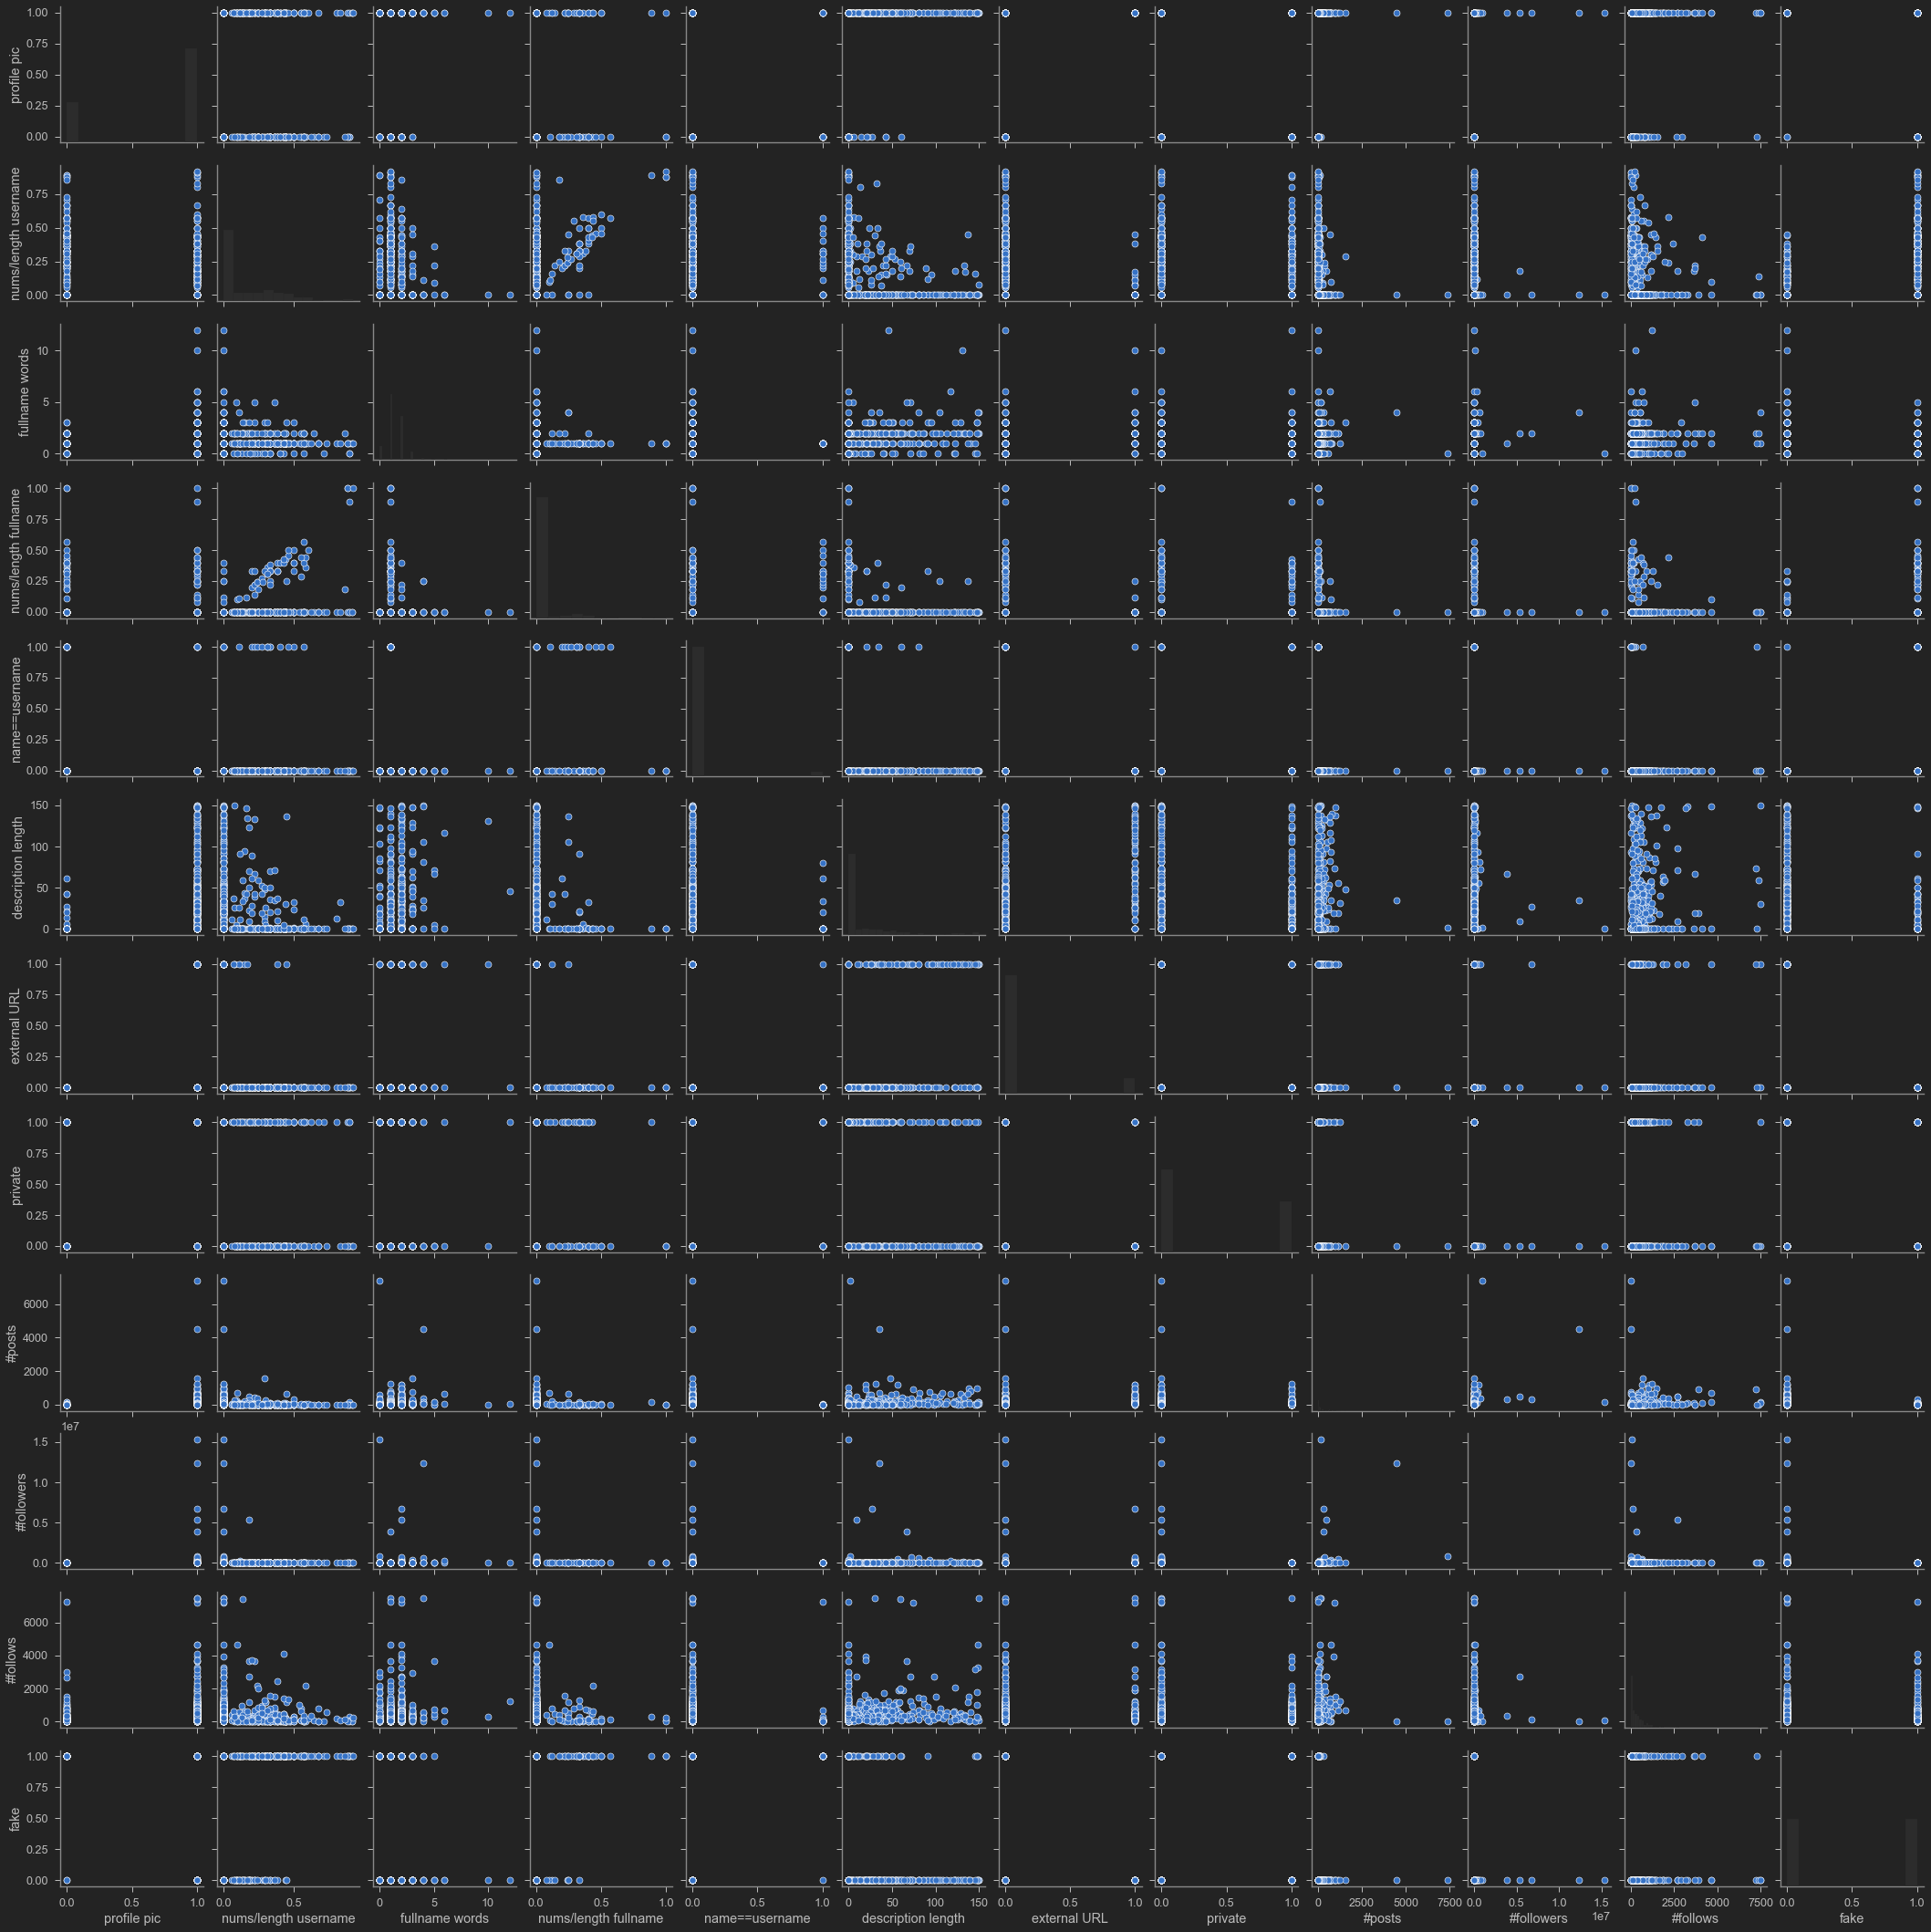

In [32]:
# Plot pairplot
plt.figure(figsize = (20, 20))
sns.pairplot(instagram_df_train)

<AxesSubplot:>

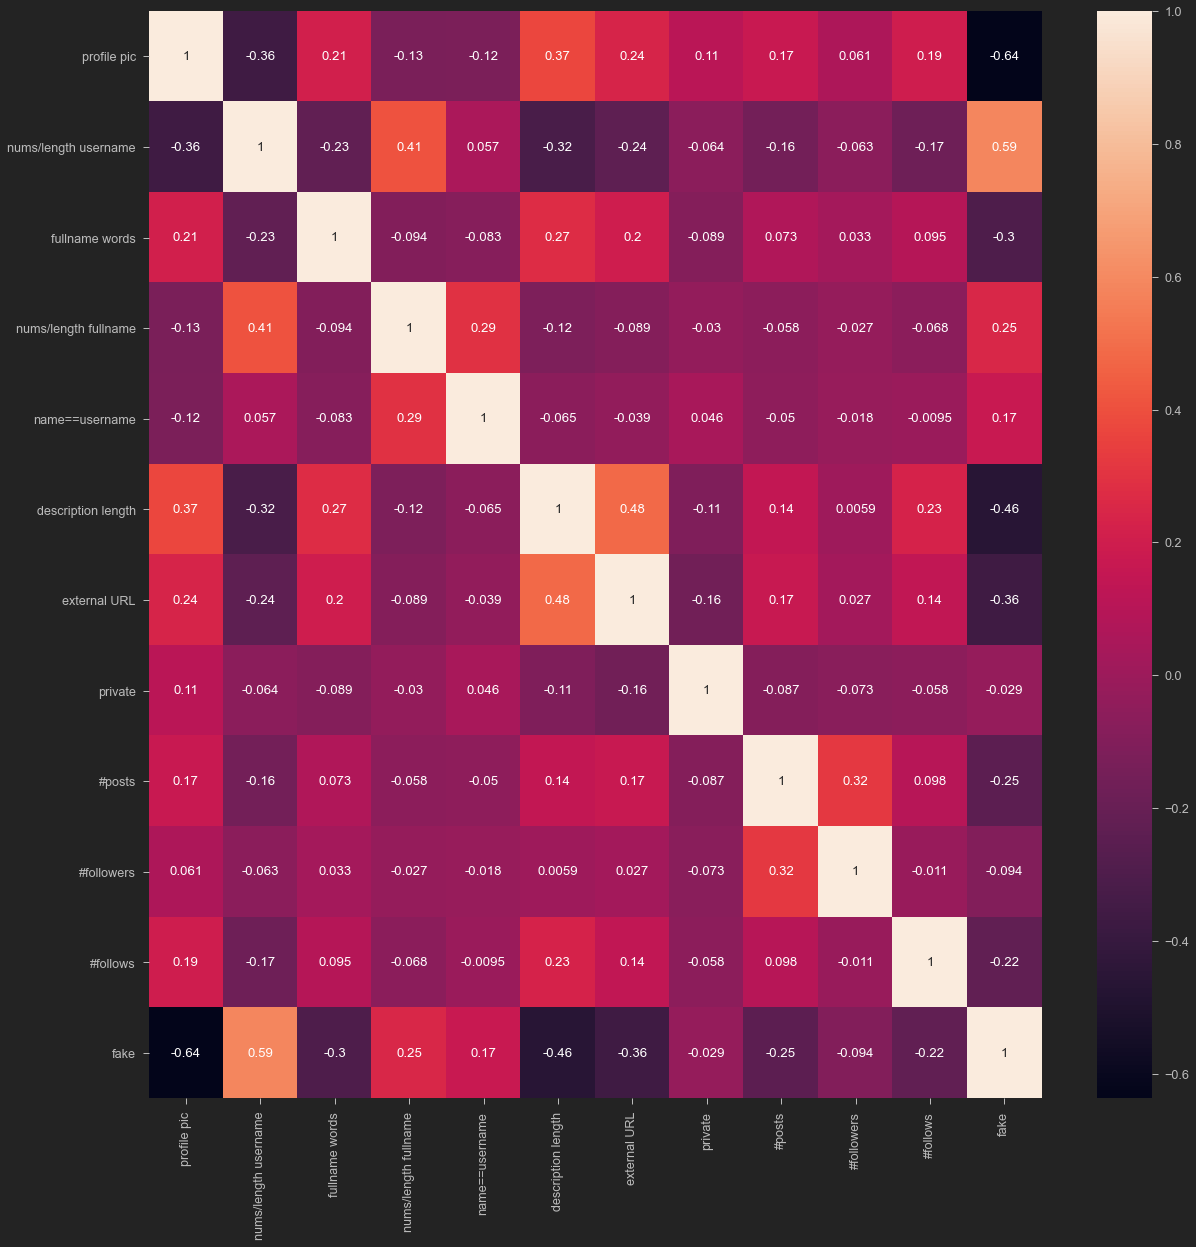

In [33]:
# Correlation plot
plt.figure(figsize=(20, 20))
cm = instagram_df_train.corr()
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

<AxesSubplot:xlabel='fake', ylabel='count'>

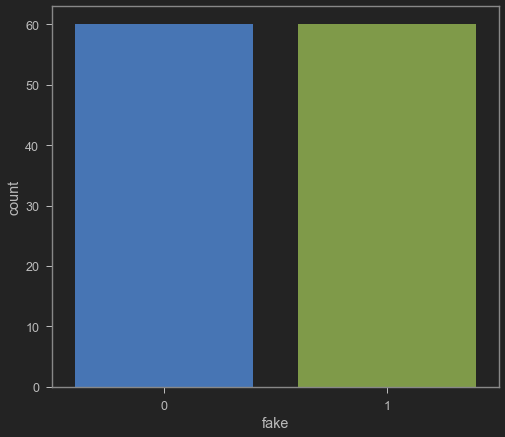

In [56]:
sns.countplot(x=instagram_df_test['fake'])

<AxesSubplot:xlabel='private', ylabel='count'>

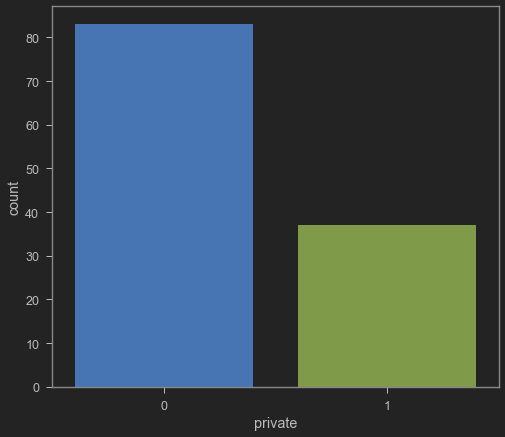

In [55]:
sns.countplot(x=instagram_df_test['private'])

<AxesSubplot:xlabel='profile pic', ylabel='count'>

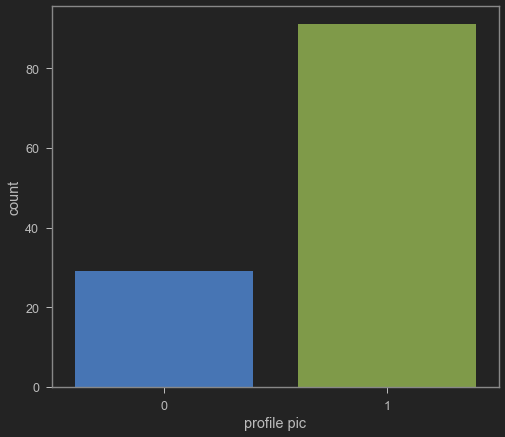

In [57]:
sns.countplot(x=instagram_df_test['profile pic'])

In [34]:
# Training and testing dataset (inputs)
X_train = instagram_df_train.drop(columns = ['fake'])
X_test = instagram_df_test.drop(columns = ['fake'])
X_train

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.27,0,0.00,0,53,0,0,32,1000,955
1,1,0.00,2,0.00,0,44,0,0,286,2740,533
2,1,0.10,2,0.00,0,0,0,1,13,159,98
3,1,0.00,1,0.00,0,82,0,0,679,414,651
4,1,0.00,2,0.00,0,0,0,1,6,151,126
...,...,...,...,...,...,...,...,...,...,...,...
571,1,0.55,1,0.44,0,0,0,0,33,166,596
572,1,0.38,1,0.33,0,21,0,0,44,66,75
573,1,0.57,2,0.00,0,0,0,0,4,96,339
574,1,0.57,1,0.00,0,11,0,0,0,57,73


In [35]:
X_test

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.33,1,0.33,1,30,0,1,35,488,604
1,1,0.00,5,0.00,0,64,0,1,3,35,6
2,1,0.00,2,0.00,0,82,0,1,319,328,668
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369
4,1,0.50,1,0.00,0,76,0,1,6,225,356
...,...,...,...,...,...,...,...,...,...,...,...
115,1,0.29,1,0.00,0,0,0,0,13,114,811
116,1,0.40,1,0.00,0,0,0,0,4,150,164
117,1,0.00,2,0.00,0,0,0,0,3,833,3572
118,0,0.17,1,0.00,0,0,0,0,1,219,1695


In [36]:
# Training and testing dataset (Outputs)
y_train = instagram_df_train['fake']
y_test = instagram_df_test['fake']

In [37]:
y_train

0      0
1      0
2      0
3      0
4      0
      ..
571    1
572    1
573    1
574    1
575    1
Name: fake, Length: 576, dtype: int64

In [38]:
y_test

0      0
1      0
2      0
3      0
4      0
      ..
115    1
116    1
117    1
118    1
119    1
Name: fake, Length: 120, dtype: int64

In [39]:
# Scale the data before training the model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

In [40]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 2)

In [41]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [42]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [58]:
# print the shapes of training and testing datasets 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((576, 11), (120, 11), (576, 2), (120, 2))

In [59]:
Training_data = len(X_train)/( len(X_test) + len(X_train) ) * 100
Training_data

82.75862068965517

In [60]:
Testing_data = len(X_test)/( len(X_test) + len(X_train) ) * 100
Testing_data

17.24137931034483

In [43]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(50, input_dim=11, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                3775      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 12,077
Trainable params: 12,077
Non-trainable params: 0
____________________________________________________

In [69]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [70]:
epochs_hist = model.fit(X_train, y_train, epochs = 20,  verbose = 1, validation_split = 0.1)

Epoch 1/20
17/17 [==============================] - 0s 10ms/step - loss: 0.6813 - accuracy: 0.5405 - val_loss: 0.4269 - val_accuracy: 0.9310
Epoch 2/20
17/17 [==============================] - 0s 2ms/step - loss: 0.4893 - accuracy: 0.8166 - val_loss: 0.3190 - val_accuracy: 0.8448
Epoch 3/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3545 - accuracy: 0.8880 - val_loss: 0.2926 - val_accuracy: 0.8448
Epoch 4/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3223 - accuracy: 0.8861 - val_loss: 0.3015 - val_accuracy: 0.8621
Epoch 5/20
17/17 [==============================] - 0s 2ms/step - loss: 0.2917 - accuracy: 0.9015 - val_loss: 0.2626 - val_accuracy: 0.8621
Epoch 6/20
17/17 [==============================] - 0s 2ms/step - loss: 0.2814 - accuracy: 0.9093 - val_loss: 0.2736 - val_accuracy: 0.8448
Epoch 7/20
17/17 [==============================] - 0s 2ms/step - loss: 0.2659 - accuracy: 0.9112 - val_loss: 0.2144 - val_accuracy: 0.8793
Epoch 8/20
17/17 [=

In [71]:
print(epochs_hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


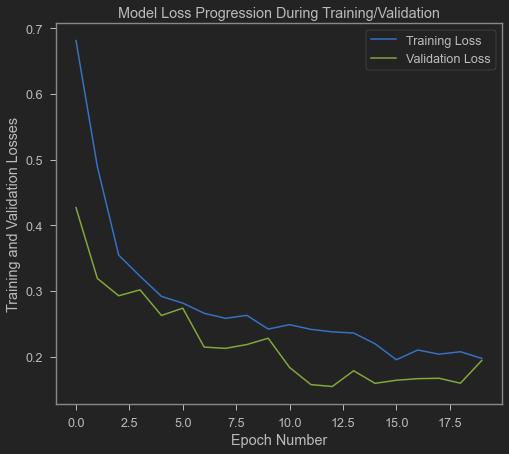

In [72]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])

plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Training and Validation Losses')
plt.xlabel('Epoch Number')
plt.legend(['Training Loss', 'Validation Loss'])

In [73]:
predicted = model.predict(X_test)

In [74]:
predicted_value = []
test = []
for i in predicted:
    predicted_value.append(np.argmax(i))
    
for i in y_test:
    test.append(np.argmax(i))

In [75]:
print(classification_report(test, predicted_value))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90        60
           1       0.93      0.85      0.89        60

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



Text(0.5, 61.0, 'predicted class')

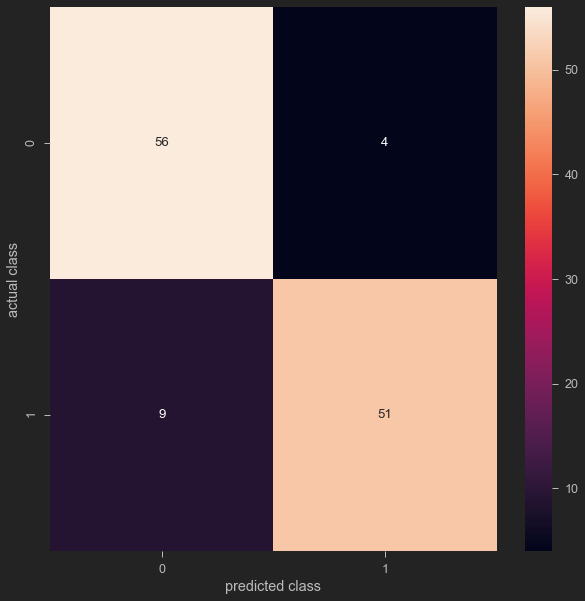

In [76]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(test, predicted_value) 
sns.heatmap(cm, annot = True)
plt.ylabel('actual class')
plt.xlabel('predicted class')